### 1.a.

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [86]:
df_raw = pd.read_csv("New York City Taxi Trip Duration .csv")
df_raw.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### 1.b.

In [87]:
df = df_raw.drop(axis=1, columns=['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag'])
df.head()

,id,pickup_longitude,pickup_latitude,trip_duration
0,id2875421,-73.982155,40.767937,455
1,id2377394,-73.980415,40.738564,663
2,id3858529,-73.979027,40.763939,2124
3,id3504673,-74.010040,40.719971,429
4,id2181028,-73.973053,40.793209,435


### 1.c.

In [88]:
df['pickup_longitude'] = (df['pickup_longitude'] - df['pickup_longitude'].min()) / (df['pickup_longitude'].max() - df['pickup_longitude'].min())
df['pickup_latitude'] = (df['pickup_latitude'] - df['pickup_latitude'].min()) / (df['pickup_latitude'].max() - df['pickup_latitude'].min())
df.head()

,id,pickup_longitude,pickup_latitude,trip_duration
0,id2875421,0.525209,0.650127,455
1,id2377394,0.529221,0.527039,663
2,id3858529,0.532424,0.633374,2124
3,id3504673,0.460889,0.449126,429
4,id2181028,0.546203,0.756031,435


In [89]:
X = df[['pickup_longitude', 'pickup_latitude']].values

### 1.d.

In [90]:
PLOTSDIR = 'plots/'

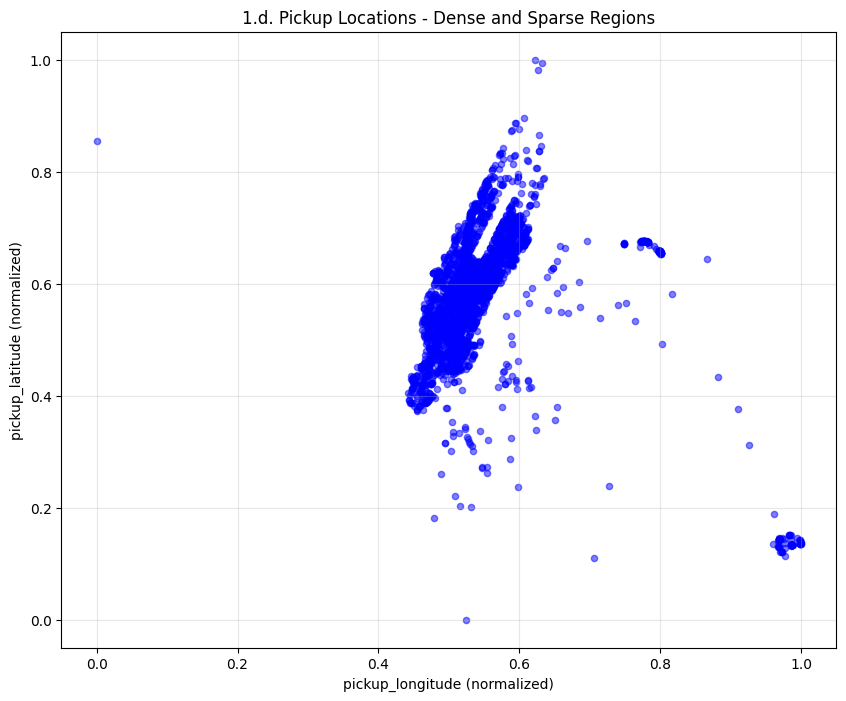

In [91]:
plt.figure(figsize=(10, 8))
plt.scatter(df['pickup_longitude'], df['pickup_latitude'], alpha=0.5, s=20, color='blue')
plt.xlabel('pickup_longitude (normalized)')
plt.ylabel('pickup_latitude (normalized)')
plt.title('1.d. Pickup Locations - Dense and Sparse Regions')
plt.grid(True, alpha=0.3)
plt.savefig(PLOTSDIR + '1d_pickup_scatter.png', dpi=100, bbox_inches='tight')
plt.show()

### 1.e.

In [92]:
def distance(point1, point2):
    return np.sum((point1 - point2)**2)

In [93]:
def get_neighbors(X, point_index, eps_squared):
    """
    Finds all points in X that are within eps (using eps_squared) of the
    point at point_index.
    
    Args:
        X (np.array): The input data (n_samples, n_features).
        point_index (int): The index of the point to find neighbors for.
        eps_squared (float): The squared epsilon (radius) for the neighborhood.

    Returns:
        list: A list of indices of the neighboring points (including the
              point itself, as min_pts includes the point).
    """
    n_samples = X.shape[0]
    center_point = X[point_index]
    neighbors_indices = []
    
    for i in range(n_samples):
        # Calculate squared distance
        dist = distance(center_point, X[i])
        
        # Check if the point is within the epsilon-neighborhood
        if dist <= eps_squared:
            neighbors_indices.append(i)
            
    return neighbors_indices

In [94]:
def expand_cluster(X, labels, point_index, cluster_id, eps_squared, min_pts, neighbors_of_start_point):
    """
    Expands a cluster from a starting core point.
    This function modifies the 'labels' array in-place.
    
    Args:
        X (np.array): The input data (n_samples, n_features).
        labels (np.array): Array of labels for each point (-2=Unclassified, -1=Noise, >=0=Cluster ID).
        point_index (int): The index of the core point to start expansion from.
        cluster_id (int): The new cluster ID to assign.
        eps_squared (float): The squared epsilon (radius) for the neighborhood.
        min_pts (int): The minimum number of points to form a dense region.
        neighbors_of_start_point (list): The pre-computed neighbors of the starting point.
    """
    
    # Label the starting core point
    labels[point_index] = cluster_id
    
    # Create a queue from the neighbors (making a copy)
    # We will process every point in this list, and add more points
    # if they are also core points.
    queue = neighbors_of_start_point[:]
    
    i = 0
    while i < len(queue):
        # Get the next point index from the queue
        current_idx = queue[i]
        
        # Case 1: Point was labeled as Noise (-1)
        # This point is density-reachable from a core point, so it's
        # a border point. It becomes part of the cluster.
        if labels[current_idx] == -1:
            labels[current_idx] = cluster_id
        
        # Case 2: Point is Unclassified (-2)
        # This is a new point to add to the cluster.
        elif labels[current_idx] == -2:
            labels[current_idx] = cluster_id
            
            # Find the neighbors of this new point
            neighbors_of_current = get_neighbors(X, current_idx, eps_squared)
            
            # Check if this new point is ALSO a core point
            if len(neighbors_of_current) >= min_pts:
                # If it is, add all its unclassified or noise neighbors
                # to the queue to be processed.
                for idx in neighbors_of_current:
                    if labels[idx] in [-1, -2]: # If Noise or Unclassified
                        if idx not in queue:
                            queue.append(idx)
                            
        # Case 3: Point is already part of this cluster or another
        # Do nothing.
        
        # Move to the next item in the queue
        i += 1
    
    # This loop finishes when the queue is empty, meaning the
    # cluster is fully expanded.


In [95]:
def dbscan_model(X, eps, min_pts):
    """
    Performs DBSCAN clustering on the dataset X.
    
    Args:
        X (pd.DataFrame or np.array): The input data (n_samples, n_features).
                                      'y' is not used (unsupervised).
        eps (float): The maximum distance between two samples for one to be
                     considered as in the neighborhood of the other (hyperparameter).
        min_pts (int): The number of samples (or total weight) in a neighborhood
                       for a point to be considered as a core point (hyperparameter).
                       This includes the point itself.

    Returns:
        np.array: An array of cluster labels for each point.
                  Noise points are labeled -1.
                  Clusters are labeled 0, 1, 2, ...
    """
    print(f'dbscan_model {min_pts} {eps}')
    # 1. Handle Input Type
    if isinstance(X, pd.DataFrame):
        X_np = X.values
    elif isinstance(X, np.ndarray):
        X_np = X
    else:
        raise TypeError("Input X must be a pandas DataFrame or a numpy array.")
        
    n_samples, _ = X_np.shape
    
    # 2. Pre-calculate eps_squared for efficiency
    eps_squared = eps**2
    
    # 3. Initialize labels array
    # -2 = Unclassified
    # -1 = Noise
    # >= 0 = Cluster ID
    labels = np.full(n_samples, -2, dtype=int)
    
    cluster_id = 0
    
    # 4. Iterate over all points
    for i in range(n_samples):
        if i%100 == 0:
            print(i)
        # Skip if point is already classified
        if labels[i] != -2:
            continue
            
        # a. Find neighbors for the current point
        neighbors = get_neighbors(X_np, i, eps_squared)
        
        # b. Check if it's a core point
        if len(neighbors) < min_pts:
            # Not a core point. Mark as Noise (for now).
            # It might be re-labeled as a border point later.
            labels[i] = -1
            continue
            
        # c. It IS a core point. Start a new cluster.
        # We pass the pre-computed neighbors to save computation.
        expand_cluster(
            X=X_np,
            labels=labels,
            point_index=i,
            cluster_id=cluster_id,
            eps_squared=eps_squared,
            min_pts=min_pts,
            neighbors_of_start_point=neighbors
        )
        
        # Increment cluster ID for the next cluster
        cluster_id += 1
        
    return labels


In [96]:
def compute_k_distances_manual(X, k):
    """
    Compute k-distances for all points without sklearn.
    Returns sorted k-distances for k-distance graph.
    """
    n_samples = X.shape[0]
    k_distances = []
    
    for i in range(n_samples):
        # Compute distances from point i to all other points
        distances_from_i = []
        for j in range(n_samples):
            dist = np.sqrt(np.sum((X[i] - X[j])**2))  # Euclidean distance
            distances_from_i.append(dist)
        
        # Sort and get k-th distance (k-th nearest neighbor, excluding self)
        distances_from_i.sort()
        k_distance = distances_from_i[k]  # k-th element (0-indexed, includes self at 0)
        k_distances.append(k_distance)
    
    # Sort k-distances for visualization
    k_distances_sorted = sorted(k_distances)
    return np.array(k_distances_sorted)

In [97]:
minpts_list = [5, 10, 15]
eps_candidates = np.linspace(0.001, 0.05, 5)

results = {}
for minpts in minpts_list:
    print(f'on {minpts}')
    best_max_cluster = 0
    best_eps_for_minpts = None
    best_labels = None

    for eps in eps_candidates:
        print(f'on {eps}')
        labels = dbscan_model(X, eps=eps, min_pts=minpts)
        # count cluster sizes (ignore noise -1)
        unique, counts = np.unique(labels[labels >= 0], return_counts=True) if np.any(labels >= 0) else (np.array([]), np.array([]))
        max_cluster_size = counts.max() if counts.size > 0 else 0

        if max_cluster_size > best_max_cluster:
            best_max_cluster = max_cluster_size
            best_eps_for_minpts = eps
            best_labels = labels.copy()

    results[minpts] = {
        'best_eps': best_eps_for_minpts,
        'best_max_cluster': best_max_cluster,
        'labels': best_labels
    }

# Pick the minpts which gives the largest reachable cluster over the eps sweep
chosen_minpts = max(results.keys(), key=lambda k: results[k]['best_max_cluster'])
print(f"Chosen minpts: {chosen_minpts}")
print(f"Best max cluster size: {results[chosen_minpts]['best_max_cluster']}")
print(f"Eps from initial sweep: {results[chosen_minpts]['best_eps']:.6f}")
print()

# K-distance graph for chosen_minpts (k = minpts - 1)
k = chosen_minpts - 1
print(f"Computing k-distance graph for k={k} (without sklearn)...")
k_distances = compute_k_distances_manual(X, k)

plt.figure(figsize=(10, 6))
plt.plot(k_distances, linewidth=1.5)
plt.xlabel(f'Points sorted by {k}-distance')
plt.ylabel(f'{k}-distance')
plt.title(f'(E) K-distance graph (k={k}) for chosen minpts={chosen_minpts}')
plt.grid(True, alpha=0.3)
plt.savefig(PLOTSDIR + f'1e_k_distance_minpts_{chosen_minpts}.png', dpi=100, bbox_inches='tight')
plt.show()

# Simple knee detection: look for max second derivative
grad1 = np.gradient(k_distances)
grad2 = np.gradient(grad1)
knee_idx = np.argmax(grad2)
eps_from_knee = k_distances[knee_idx]
print(f"Detected eps from knee detection: {eps_from_knee:.6f} (at index {knee_idx})")
print()

# Final DBSCAN with detected eps
final_labels = dbscan_model(X, eps=eps_from_knee, min_pts=chosen_minpts)

# Plot final clusters
unique_labels = np.unique(final_labels)
n_clusters = len(unique_labels[unique_labels >= 0])
n_noise = np.sum(final_labels == -1)

colors = plt.cm.get_cmap('tab20', max(n_clusters, 1))
plt.figure(figsize=(10, 8))
for lbl in unique_labels:
    mask = final_labels == lbl
    if lbl == -1:
        plt.scatter(X[mask, 0], X[mask, 1], c='k', marker='x', s=30, linewidths=0.5, label=f'Noise ({n_noise})')
    else:
        cluster_size = np.sum(mask)
        plt.scatter(X[mask, 0], X[mask, 1], color=colors(lbl % 20), s=20, alpha=0.7, label=f'Cluster {lbl} ({cluster_size})')

plt.legend(markerscale=1.5, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel('pickup_longitude (normalized)')
plt.ylabel('pickup_latitude (normalized)')
plt.title(f'(E,F) DBSCAN Clusters (minpts={chosen_minpts}, eps={eps_from_knee:.6f})')
plt.grid(True, alpha=0.3)
plt.savefig(PLOTSDIR + f'1ef_dbscan_clusters_minpts_{chosen_minpts}.png', dpi=100, bbox_inches='tight')
plt.show()


on 5
on 0.001
dbscan_model 5 0.001
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
on 0.013250000000000001
dbscan_model 5 0.013250000000000001
0


KeyboardInterrupt: 

### 1.f.

In [ ]:
if np.any(final_labels >= 0):
    uniq, cnts = np.unique(final_labels[final_labels >= 0], return_counts=True)
    cluster_info = sorted(zip(uniq, cnts), key=lambda x: x[1], reverse=True)
    
    print(f"Total clusters found: {len(cluster_info)}")
    print(f"Total noise points: {n_noise}")
    print()
    print("Cluster Details (sorted by size):")
    print("-" * 100)
    print(f"{'Cluster':<10} {'Size':<10} {'Centroid (lon, lat)':<35} {'Avg Trip Duration (s)':<25}")
    print("-" * 100)
    
    for lab, size in cluster_info:
        # Get points in this cluster
        mask = final_labels == lab
        pts = X[mask]
        centroid = pts.mean(axis=0)
        
        # Get average trip duration for this cluster
        indices_in_cluster = np.where(mask)[0]
        trip_durations = df.iloc[indices_in_cluster]['trip_duration'].values
        avg_trip_duration = trip_durations.mean()
        
        print(f"{lab:<10} {size:<10} ({centroid[0]:.4f}, {centroid[1]:.4f}){'':<15} {avg_trip_duration:<25.2f}")
    
    print("-" * 100)
    largest_label = cluster_info[0][0]
    print(f"\nRegion with maximum pickups: Cluster {largest_label}, Size: {cluster_info[0][1]}")
    print()
else:
    print("No clusters found with the detected eps/minpts combination.")
    print()


### 1.g.

In [ ]:
noise_mask = final_labels == -1
noise_count = np.sum(noise_mask)
total_points = len(final_labels)
noise_percentage = (noise_count / total_points) * 100

print(f"Total noise points (outliers): {noise_count}")
print(f"Total points: {total_points}")
print(f"Noise percentage: {noise_percentage:.2f}%")
print()

# Plot noise points separately
if noise_count > 0:
    plt.figure(figsize=(10, 8))
    
    # Plot all clusters
    for lbl in np.unique(final_labels[final_labels >= 0]):
        mask = final_labels == lbl
        plt.scatter(X[mask, 0], X[mask, 1], s=20, alpha=0.3, label=f'Cluster {lbl}')
    
    # Highlight noise points
    noise_pts = X[noise_mask]
    plt.scatter(noise_pts[:, 0], noise_pts[:, 1], c='red', marker='x', s=100, linewidths=2, label=f'Noise ({noise_count})')
    
    plt.xlabel('pickup_longitude (normalized)')
    plt.ylabel('pickup_latitude (normalized)')
    plt.title(f'(G) Noise Points / Outliers Detection (minpts={chosen_minpts}, eps={eps_from_knee:.6f})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(True, alpha=0.3)
    plt.savefig(PLOTSDIR + '1g_noise_points.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Statistics for noise points
    noise_indices = np.where(noise_mask)[0]
    noise_trip_durations = df.iloc[noise_indices]['trip_duration'].values
    
    print("Noise Points Statistics:")
    print(f"  Average trip duration (noise): {noise_trip_durations.mean():.2f} seconds")
    print(f"  Min trip duration (noise): {noise_trip_durations.min():.2f} seconds")
    print(f"  Max trip duration (noise): {noise_trip_durations.max():.2f} seconds")
    print(f"  Std dev (noise): {noise_trip_durations.std():.2f} seconds")
    print()

print("=" * 80)
print("Analysis Summary:")
print("=" * 80)
print("- DBSCAN successfully identified dense pickup regions (clusters)")
print("- The k-distance graph helped determine the optimal eps parameter")
print("- Noise points represent isolated pickups outside main clusters")
print("- Cluster analysis reveals geographical hotspots of taxi demand")
print("=" * 80)